# Plots

In this notebook are collected the reading and plotting functions for all the visualizations in the paper.

**Index**
 - [Shared code](#shared-code)
   - [Imports](#imports)
   - [Layout proprierties](#layout-proprierties)
 - [Boot time experiments](#boot-time)
 - [Isolation experiments](#isolation)
   - [Results reading](#isolation-results-reading)
   - [Data processing](#isolation-data-processing)
   - [Combined disturbs](#isolation-plots---combined-disturbs)
   - [Individual disturb](#isolation-plots---individual-disturb)
 - [Taclebench experiments](#taclebench-experiments)
   - [Results reading and processing](#taclebench-results-reading-and-processing)
   - [Utilities](#taclebench-plotting-utilities)
   - [Plots](#taclebench-plots)

## Shared code

### Imports

In [1]:
# All imports
import os
import sys
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import floor, ceil
from matplotlib.patches import Rectangle
from matplotlib.patches import FancyArrowPatch

### Layout proprierties

In [2]:
plots_fig_size = (10, 6)
labels_fontsize = 23
ticks_fontsize = 18
plot_linewidts = 2.5

core_color = {
    'RPU': '#F9665E',
    'RISCV': '#799FCB',
    'Constrained': '#8BB3B5' #'#80179E'
}

isolation_style = {
    'None': {
        'RPU': '-',
        'RISCV': '-',
    },
    'Spatial': {
        'RPU': '--',
        'RISCV': '--',
    },
    'Full': {
        'RPU': (0, (1, 3)),
        'RISCV': (2, (1, 3)),
    },
}

disturb_color = {
    'APU': '#A88EB3',
    'RPU1': '#FFCC99',
    'FPGA1': '#8BB3B5',
    'FPGA2': '#ADCECF',
    'FPGA': '#8BB3B5'
}

activation_colors = {
    True: "#8CC36C",
    False: "#B85450"
}

custom_legend_labels = {
    'None': 'Legacy',
    'Spatial': 'Spatial',
    'Full': 'Full'
}

### Global reading utilities

### Sorting utilities

In [3]:
sortedCores = ['RPU', 'RISCV']
sortedIsolations = ['Full', 'Spatial', 'None']

def keyOfIsolation(isolation):
    return ['None', 'Spatial', 'Full'].index(isolation)

## Boot time

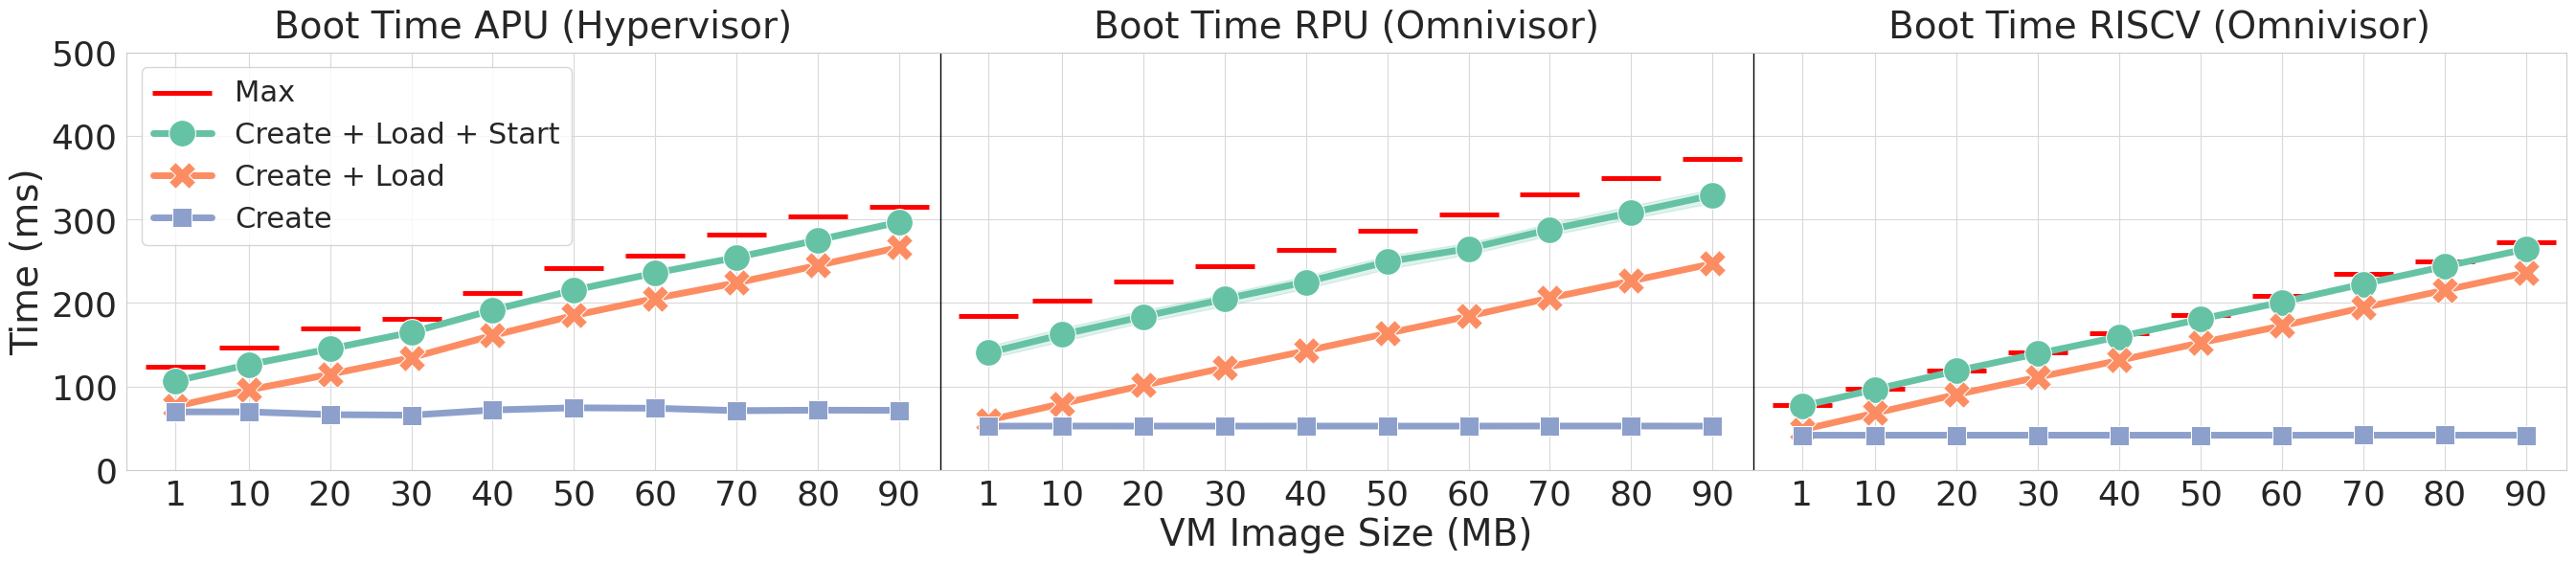

In [4]:
frequency = 100000
limit = 4294967295  # int of 0xFFFFFFFF

# TODO [POROC]
##  
## [🗸] Cambiare y testi
## [🗸] Legende
## [🗸] Spazio bianco

# Create output directory if it doesn't exist
output_directory = "./imgs"
results_directory = '../results/boot_results'
os.makedirs(output_directory, exist_ok=True)

# Read the input files
stages = ['init_time', 'create_time', 'load_time', 'boot_time']
# pstages = ['Init', 'Create', 'Load', 'Boot']
# labels = [None, 'Create', 'Create + Load', 'Create + Load + Boot']
pstages = ['Init', 'Create', 'Create + Load', 'Create + Load + Start']
dataframes = {}

# Plot with Seaborn
plt.figure(figsize=(27, 6))

for i, core in enumerate(['APU', 'RPU', 'RISCV']):
    core_dataframes = {}
    # Retrieve datas from files
    for j, stage in enumerate(stages):
        file_path = os.path.join(results_directory, f'boot_{core.upper()}/{stage}.txt')
        core_dataframes[pstages[j]] = pd.read_csv(file_path, header=None, delimiter=" ", names=['Time', 'Image Size'])
    
    # Calculate the time differences
    for j, stage in enumerate(pstages[1:]):
        core_dataframes[stage]['Time'] = [(end - start) / frequency if end > start else (end + (limit - start)) / frequency
                                          for start, end in zip(core_dataframes['Init']['Time'], core_dataframes[stage]['Time'])]
    
    # Concatenate dataframes
    pd_keys=pstages[1:]
    pd_keys.reverse()
    core_df = pd.concat(core_dataframes, keys=pd_keys)
    core_df.index.names = ['Stage', 'Index']

    dataframes[core] = core_df
    
    # Calculate the maximum and minimum for each Image Size
    max_core_df = core_df.groupby('Image Size')['Time'].max().reset_index()
    
    # Save dataframe to file
    with open(os.path.join(results_directory, f'boot_{core}/{core}_boot_times.txt'), 'w') as file:
        pd.set_option('display.max_rows', None)  # Set the option to display all rows
        file.write(str(core_df))
    
    # Save max values to file
    with open(os.path.join(results_directory, f'boot_{core}/Max_{core}_boot_times.txt'), 'w') as file:
        pd.set_option('display.max_rows', None)  # Set the option to display all rows
        file.write(str(max_core_df))

    core_df['Image Size'] += 100 * i
    max_core_df['Image Size'] += 100 * i

    # sns.set_style("whitegrid")
    sns.set_style("whitegrid", {"grid.color": ".85"})
    sns.scatterplot(data=max_core_df, x='Image Size', y='Time', color='red',#activation_colors[False],
                     marker='_', s=2000, label='Max' if i == 0 else None)
    sns.lineplot(data=core_df, x='Image Size', y='Time', hue='Stage', linewidth=5, style='Stage',
                    palette='Set2', #[activation_colors[True] , disturb_color['RPU1'], disturb_color['FPGA2']],
                 markers=True, dashes=False, markersize=20, errorbar=('ci', 100),
                 legend=None if i > 0 else 'auto')

    if i > 0:
        plt.axvline(x=100 * i - 5, linestyle='-', linewidth=1, alpha=1, color='black')
    plt.text(100 * i + 45, 530, f"Boot Time {core} ({'Hypervisor' if core == 'APU' else 'Omnivisor'})", ha='center', va='center', fontsize=28)

def create_xticks(i):
    xticks = [j for j in range(0, i * 100, 10)]
    xlabels = []
    for j in range(i):
        xticks[j*10] = 1 + j * 100
        xlabels += xticks[:10]
    return xticks, xlabels

# Adjust plot details
plt.xlim(-5, 100*3 -5)
plt.ylim(0, 500)

xticks, xlabels = create_xticks(3)

plt.xticks(xticks, labels=xlabels, fontsize=26)
plt.yticks(fontsize=26)
plt.ylabel("Time (ms)", fontsize=28)
plt.xlabel("VM Image Size (MB)", fontsize=28)
# plt.title(f"Boot Times {core}", fontsize=28)
plt.legend(loc='upper left', fontsize=22)
plt.tight_layout()
    
# Save the image
plt.savefig(os.path.join(output_directory, f"boot_times_ALL.png"))

plt.show()

## Isolation experiments

### Isolation results reading

In [5]:
# Directory containing the tests results
results_directory = '../results/isolation_results'

# Get all the txt files in the directory
txt_files = [file for file in os.listdir(results_directory) if file.endswith(".txt")]

# Empty array to collect the results from the txt files
files_data = []

isoexp_isolation_labels = {
    'spt_tmp': 'Full',
    'spt': 'Spatial',
    '': 'None'
}

def read_isolation_results_file(filename):

    # Get complete file path and read data from result file
    file_path = os.path.join(results_directory, filename)
    with open(file_path, "r") as f:
        data = [int(line.strip()) / 1000 for line in f][:100]
    
    # Extract the core, disturb and isolation from the file name
    segments = '.'.join(filename.split('.')[:-1]).split("_")
    core, disturb = segments[:2]
    isolation = isoexp_isolation_labels['_'.join(segments[2:])]

    return [(time, core, isolation, disturb, value if value > 0 else None) for value, time in zip(data, np.arange(0, 20, .2))]

# pp([read_isolation_results_file(file) for file in txt_files])
isolation_raw_data = [line for file in txt_files for line in read_isolation_results_file(file) ]

# Iterate over the txt files
for file in txt_files:

    # Get complete file path and read data from result file
    file_path = os.path.join(results_directory, file)
    with open(file_path, "r") as f:
        data = [int(line.strip()) / 1000 for line in f][:100]
    
    # Extract the core, disturb and isolation from the file name
    segments = '.'.join(file.split('.')[:-1]).split("_")
    core, disturb = segments[:2]
    isolation = isoexp_isolation_labels['_'.join(segments[2:])]

    tmp = [(time, core, isolation, disturb, value if value > 0 else None) for value, time in zip(data, np.arange(0, 20, .2))]
    tmp_1 = read_isolation_results_file(file)

    # pp(tmp)
    # pp(tmp_1)
    # pp([a for a in zip(tmp, tmp_1)])

    files_data += [(time, core, isolation, disturb, value if value > 0 else None) for value, time in zip(data, np.arange(0, 20, .2))]


isolation_df = pd.DataFrame(isolation_raw_data, columns=['Time', 'Core', 'Isolation', 'Disturb', 'Value'])

# Initialize a DataFrame of all the data
files_df = pd.DataFrame(files_data, columns=['Time', 'Core', 'Isolation', 'Disturb', 'Value'])

# Create the imgs directory if it doesn't exist
output_directory = "./imgs"
os.makedirs(output_directory, exist_ok=True)

### Isolation data processing

In [6]:
isolation_df_all = isolation_df.copy()

isolation_df_individual = files_df.copy()
isolation_df_individual = pd.DataFrame(isolation_df_individual[(isolation_df_individual.Disturb != 'NONE') & (isolation_df_individual.Disturb != 'ALL')])

# Baselines
bl = dict(
            isolation_df_individual[(isolation_df_individual.Value > 0)]
                .groupby(['Disturb', 'Core'])
                .min()
                .reset_index()
                .apply(lambda r: ((r.Core, r.Disturb), r.Value), axis = 1)
                .array
        )

def to_slowdown(row):
    # if not np.isnan(row.Value):
    row.Value /= bl[(row.Core, row.Disturb)]
    return row
    
isolation_df_individual = isolation_df_individual.apply(to_slowdown, axis = 1)

### Isolation plots - Combined disturbs

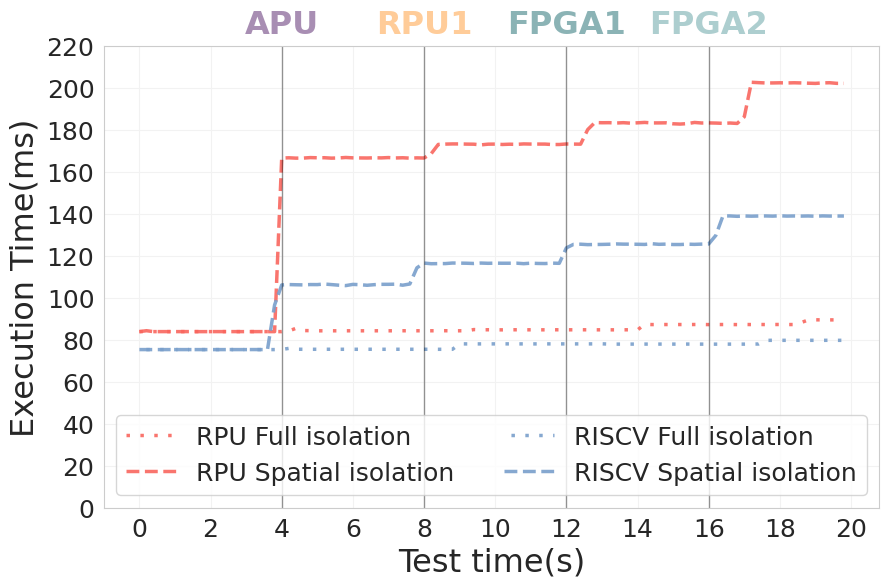

In [7]:
plt.figure(figsize=plots_fig_size)
sns.set_style("whitegrid", {"grid.color": ".95"})
ax = plt.gca()

for core in sortedCores:
    for isolation in sortedIsolations[:2]:
        ax = sns.lineplot(
                x='Time', y='Value',
                data=isolation_df_all[(isolation_df_all.Disturb == 'ALL') & (isolation_df_all.Core == core) & (isolation_df_all.Isolation == isolation)],
                label=f'{core} {isolation} isolation',
                linewidth=plot_linewidts,
                color=core_color[core],
                linestyle =isolation_style[isolation][core],
                alpha=0.9,
                ax=ax)

ax.yaxis.grid(True)

plt.xticks(np.arange(0, 22, 2), fontsize=ticks_fontsize)
plt.yticks(np.arange(0, 221, 20),fontsize=ticks_fontsize)

for i, disturb in enumerate(['APU', 'RPU1', 'FPGA1', 'FPGA2']):
    plt.text(4 * (i + 1), 230, disturb, fontsize=labels_fontsize, weight='bold', ha='center', va='center', color=disturb_color[disturb])
    plt.axvline(x=4 * (i + 1), linestyle='-', linewidth=1, alpha=0.4, color='black')

plt.xlabel("Test time(s)", fontsize=labels_fontsize)
plt.ylabel("Execution Time(ms)", fontsize=labels_fontsize)

plt.legend(
    # bbox_to_anchor=(0.5, 1.07),
    loc='lower center', fontsize=ticks_fontsize, ncol=2)

# Save the plot in the specified directory
plt.savefig(os.path.join(output_directory, ("RISCV_RPU_ALL.png")))

### Isolation plots - Individual disturb

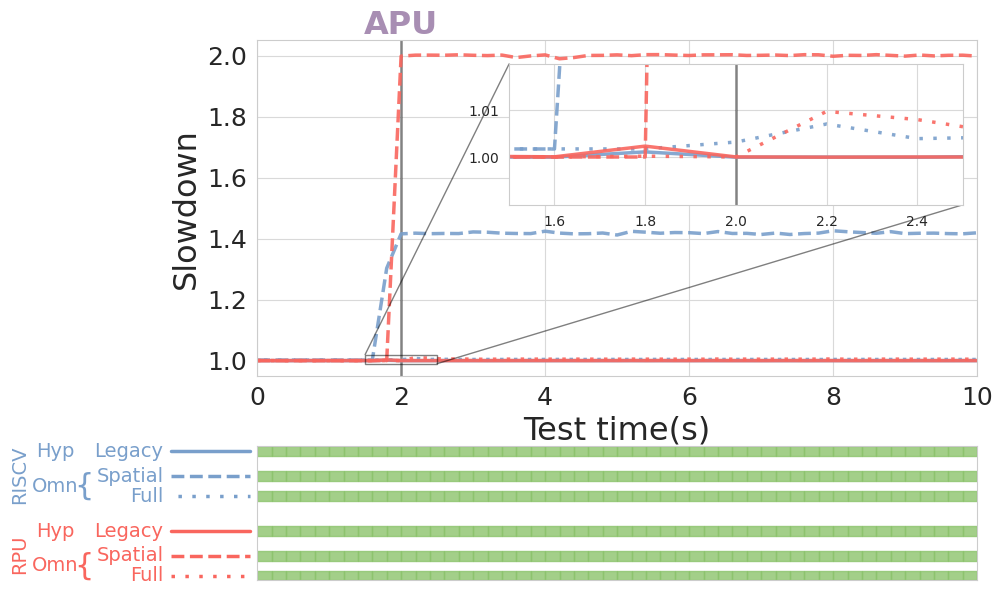

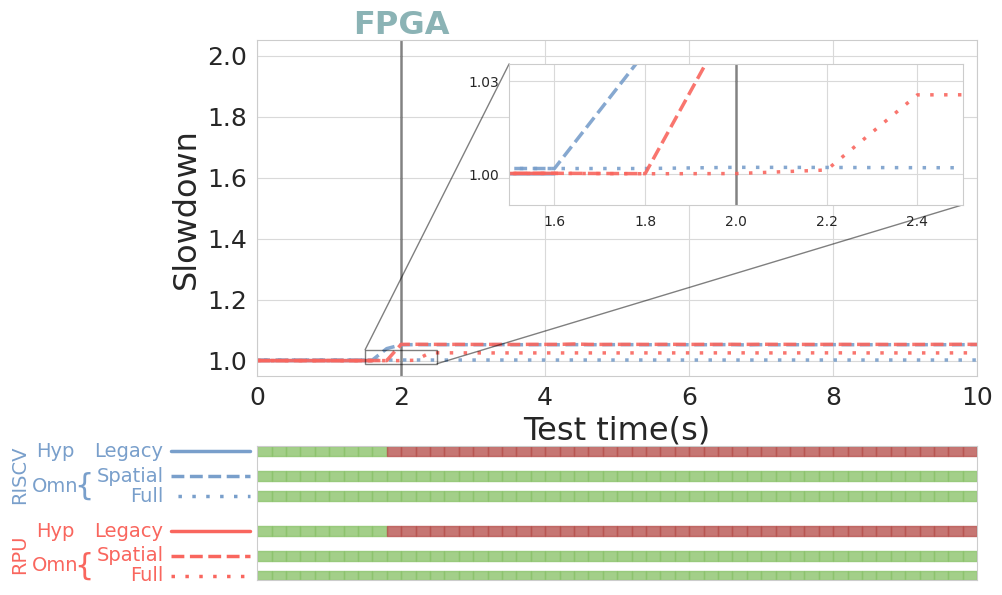

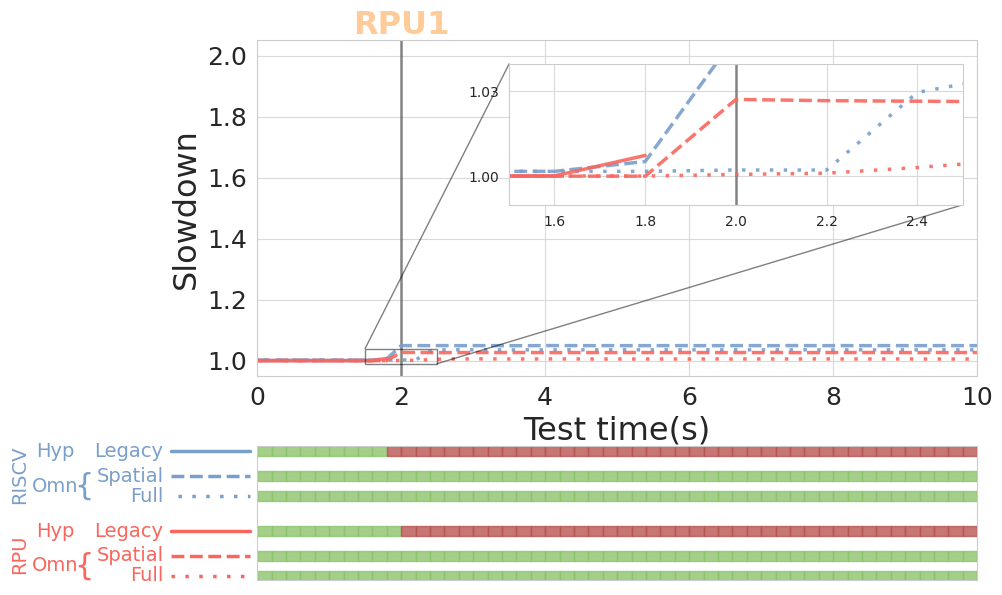

In [8]:
sns.set_style("whitegrid", {"grid.color": ".85"})

for disturb, disturb_df in isolation_df_individual.groupby('Disturb'):

    # Create a line plot using seaborn
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=plots_fig_size, gridspec_kw={'height_ratios': [5, 2]})
    plt.sca(ax1)

    max_slowdown = disturb_df[(disturb_df.Time > 1.9) & (disturb_df.Time < 2.5) & (disturb_df.Isolation != 'Spatial')].Value.max()
    

    axins = ax1.inset_axes(
            [0.35, 0.51, 0.63, 0.42],
            xlim=(1.5, 2.5), ylim=(.99, max_slowdown + .01),
            yticks=[1, floor((max_slowdown + .01) * 100)/ 100]
        )

    ax1.indicate_inset_zoom(axins, edgecolor="black")
    ax1.axvline(x=2, linestyle='-', linewidth=2, alpha=0.4, color='black')
    axins.axvline(x=2, linestyle='-', linewidth=2, alpha=0.4, color='black')
    ax2.axis('on')

    for core, disturb_core_df in disturb_df.groupby('Core'):
        i = sortedCores.index(core)

        core_base_y = i * .8
        ax2.text(-2.8, core_base_y + .5, 'Hyp', va='center', ha='center', color=core_color[core], rotation='horizontal', fontsize=14)
        ax2.text(-2.8, core_base_y + .5 * .2 + .05, 'Omn', va='center', ha='center', color=core_color[core], rotation='horizontal', fontsize=14)
        ax2.text(-2.4, core_base_y + .5 * .2 + .05, '{', va='center', ha='center', color=core_color[core], rotation='horizontal', fontsize=22)
        ax2.text(-3.3, core_base_y + .2 + .05 + .05/3, core, va='center', ha='center', color=core_color[core], rotation='vertical', fontsize=14)
        
        for isolation, line_df in disturb_core_df.groupby('Isolation'):
            k = sortedIsolations.index(isolation)

            for __ax in [ax1, axins]:
                sns.lineplot(data=line_df, x='Time', y='Value', linewidth=plot_linewidts, alpha=0.9, color=core_color[core], linestyle = isolation_style[isolation][core], ax=__ax)


            line_y = core_base_y + k * .2 + (0 if k < 2 else .05) + .05
            ax2.axhline(y = line_y, xmin = -.12, xmax = -.01, color=core_color[core], linestyle=isolation_style[isolation][core], linewidth=2.5, clip_on=False)

            for k1, v1 in enumerate(line_df.Value):
                ax2.add_patch(Rectangle((k1 * .2, line_y - .05), .2, 0.1, color=activation_colors[not np.isnan(v1)], alpha=0.8))
            
            ax2.text(-1.3, line_y, custom_legend_labels[isolation], va='center', ha='right', color=core_color[core], fontsize=14)

    plt.text(2, 2.1, disturb, fontsize=labels_fontsize, weight='bold', ha='center', va='center', color=disturb_color[disturb])
    
    plt.xlabel("Test time(s)", fontsize=labels_fontsize)
    plt.ylabel("Slowdown", fontsize=labels_fontsize)
    plt.xticks(np.arange(0, 22, 2), fontsize=ticks_fontsize)
    plt.yticks(fontsize=ticks_fontsize)
    plt.ylim(.95, 2.05)
    plt.xlim(0, 10)

    axins.set_ylabel('')
    axins.set_xlabel('')

    plt.sca(ax2)

    ax2.set_xlim(0, 10)
    ax2.set_ylim(0, 1.35)
    plt.xticks(np.arange(0, 12, 2), fontsize=13)
    
    plt.yticks([])
    plt.xticks([])
    plt.subplots_adjust(left=0.25, right=.97, hspace=.3, bottom=.05, top=.95)

    plt.savefig(os.path.join(output_directory, f"{disturb}_plot.png"))
    plt.show()



## Taclebench experiments

### Taclebench results reading and processing

In [9]:
# Directory path for the experiment results
results_dir = '../results/taclebench_results'

# Get the list of experiment directories
experiment_dirs = os.listdir(results_dir)

# Create ouput directory if it doesn't exist
output_directory = "./imgs"
os.makedirs(output_directory, exist_ok=True)

def extract_taclebench_data(benchmark, core):
    search_results = f"{results_dir}/{benchmark}/{benchmark}_{core}_SEARCH.txt"

    if not os.path.isfile(search_results):
        print(f"No file {search_results}")
        return (None, None)
    try:
        df = pd.read_csv(search_results, skiprows=[0])
        if len(df[df.time > 0]) == 0:
            return (None, None)
    except Exception as e:
        print(e)
        os.rename(search_results,  f"{results_dir}/{benchmark}/{benchmark}_{core}_SEARCH_corrupted.txt")
        return (None, None)

    full_df = df.copy()
    
    # Group values by bandwidth and compute some statistics on the repetions
    df = df.groupby(['bandwidth']).agg({"time":'mean', 'rep':'count', 'in_target': 'sum', 'slowdown':'mean'}).reset_index()
    
    # Extract max bandwidth slowdown
    max_bandwidth = df.bandwidth.max()
    max_bandwidth_slowdown = df[df.bandwidth == max_bandwidth].slowdown.iloc[0]

    # Filter out incomplete iterations
    df = df[(df['in_target'] == df['rep'])]

    best_bandwidth = df['bandwidth'].max()
    best_bandwidth_slowdown = df[df['bandwidth'] == best_bandwidth].slowdown.iloc[0]

    full_df = full_df[(full_df.bandwidth == max_bandwidth) | (full_df.bandwidth == best_bandwidth)][['bandwidth', 'slowdown']]
    full_df['benchmark'] = benchmark
    full_df['core'] = core
    full_df['experiment'] = full_df.apply(lambda row: 'Unconstrained' if row.bandwidth == max_bandwidth else 'Constrained', axis=1)

    return (full_df, [benchmark, core, max_bandwidth_slowdown, best_bandwidth_slowdown, best_bandwidth])

taclebench_df, stats = zip(*[(a, b) for core in ['RPU', 'RISCV'] for a, b in [extract_taclebench_data(benchmark, core) for benchmark in experiment_dirs] if (not a is None) and (not b is None)])
taclebench_df = pd.concat(taclebench_df)

taclebench_stats = pd.DataFrame(data=stats, columns=['benchmark', 'core', 'unconstrained_slowdown', 'contrained_slowdown', 'constrained_bandwidth'])

### Taclebench plotting utilities

In [10]:
labels_size=18
ticks_size=13

In [11]:
def calc_sorting_and_line_data(stats):
    sorted_benchmarks = stats.sort_values(by=['unconstrained_slowdown'])['benchmark']

    line_data = sorted_benchmarks.copy().reset_index()['benchmark'].reset_index().rename(columns={'index': 'x'})
    line_data = line_data.join(stats[['benchmark', 'constrained_bandwidth']].set_index('benchmark'), on='benchmark')
    line_data.x = line_data.x.map(lambda x: x + .5)

    line_zero = line_data.loc[[0]]
    line_zero.x = line_zero.x.map(lambda x: x - 1)

    line_data = pd.concat([line_zero, line_data])

    return sorted_benchmarks, line_data

In [12]:
def taclebench_plot(full_res_df, stats, ax1, splitted=False, left=True, right=False, slowdown_ylim=None, max_slowdown=None, ticks_count=6):

    if not splitted:
        left = True
        right = True

    sorted_benchmarks, line_data = calc_sorting_and_line_data(stats)

    plt.sca(ax1)
    ax1.xaxis.grid(False)

    barplot1 = sns.barplot(x='benchmark', 
                y='slowdown',
                hue='experiment',
                palette=[core_color['RISCV'], disturb_color['RPU1']],
                data=full_res_df, 
                order=sorted_benchmarks,
                linewidth=1.5,
                errorbar=('ci', 100),
                capsize=0.1,
                estimator=np.mean,
                ax=ax1
    )

    plt.axhline(y=1.2, color='black', linestyle=":", label='Target max')

    xlim = ax1.get_xlim()

    # Rotate x-axis labels and add grid lines
    plt.xticks(rotation=45, fontsize=ticks_size, ha='right')
    plt.yticks(fontsize=ticks_size)
    
    max_slowdown = full_res_df.slowdown.max()

    if slowdown_ylim is None:
        slowdown_ylim = max_slowdown * 1.1

    # i = 0
    # while plt.yticks()[0][-(i - 1)] < max_slowdown:
    #     i += 1

    plt.ylim(1, slowdown_ylim)

    if splitted:
        plt.ylim(plt.yticks()[0][0], plt.yticks()[0][-1])

    if left:
        plt.ylabel("Slowdown", fontsize=labels_size)
    else:
        plt.ylabel(None)

    plt.xlabel(None)

    if splitted:
        ticks = [t for t in np.linspace(plt.ylim()[0], plt.ylim()[1], ticks_count)]
        if not 1.2 in ticks:
            ticks += [1.2]
        plt.yticks(ticks)

    ax2 = ax1.twinx()
    ax2.xaxis.grid(False)

    if splitted:
        ax1.yaxis.set_major_formatter(lambda tick, _: f"{floor(tick * 1000)/1000}x")
        if right:
            ax2.yaxis.set_major_formatter(lambda tick, _: f"{int(tick * 10) / 10} MB/s")
        else:
            ax2.yaxis.set_major_formatter(lambda tick, _: f"{int(tick)} MB/s")
    else:
        ax1.yaxis.set_major_formatter(lambda tick, _: f"{floor(tick * 1000)/1000}x")
        ax2.yaxis.set_major_formatter(lambda tick, _: f"{floor(tick *10) / 10} MB/s")


    lineplot1 = sns.lineplot(x='x', 
                y='constrained_bandwidth',
                # color='black',
                color=disturb_color['RPU1'],
                label='Regulated bandwidth level',
                data=line_data, 
                linewidth=2.5,
                ax=ax2,
                drawstyle='steps'
    )

    h1, l1 = barplot1.get_legend_handles_labels()
    h2, l2 = lineplot1.get_legend_handles_labels()


    plt.xlim(xlim)
    # plt.xlim((xlim[0] + 3, xlim[1]))
    tmp_ylim = plt.ylim()
    if splitted:
        if right:
            # plt.ylim(tmp_ylim[0], bw_line_df.bandwidth.max() * 1.1)
            plt.ylim(8, 18.5)
        else:
            plt.ylim(0, 350)
    else:
         plt.ylim(3 - .5, ceil(tmp_ylim[1]) - .5)
    # plt.ylim(3 - .5, 20 - .5)
    # plt.ylim((floor(tmp_ylim[0]), ceil(tmp_ylim[1])))
    # plt.yticks(np.arange(3, 12.5, 1.5) - .5, fontsize=ticks_size)
    plt.xticks(fontsize=ticks_size)
    # print(plt.yticks())
    # plt.ylim(plt.yticks()[0][0], plt.yticks()[0][-1])
    
    # np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1], 5)
    # ax1.set_yticks(np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1], 6))
    if splitted:
        plt.yticks(np.linspace(plt.ylim()[0], plt.ylim()[1], ticks_count))
        # plt.yticks(plt.yticks()[0] + [1.2])
        plt.yticks(fontsize=ticks_size)
    else:
        plt.yticks(np.arange(3, 12.5, 1.5) - .5, fontsize=ticks_size)

    if right:
        plt.ylabel("Bandwidth (MB/s)", fontsize=labels_size)
    else:
        plt.ylabel(None)

    plt.xlabel(None)
    # plt.xlabel("Benchmark", fontsize=labels_size)

    plt.tight_layout()
    barplot1.get_legend().remove()
    
    if right:
        lineplot1.legend(h1 + h2,
                            [l + " slowdown (x)" for l in l1] + [f"{l} (MB/s)" for l in l2],
                            # bbox_to_anchor=(0.5, 1.03),
                            bbox_to_anchor=(0.5, 1.03),
                            loc='upper center', fontsize=labels_size-2, ncol=2)
    else:
        lineplot1.get_legend().remove()


### Taclebench plots

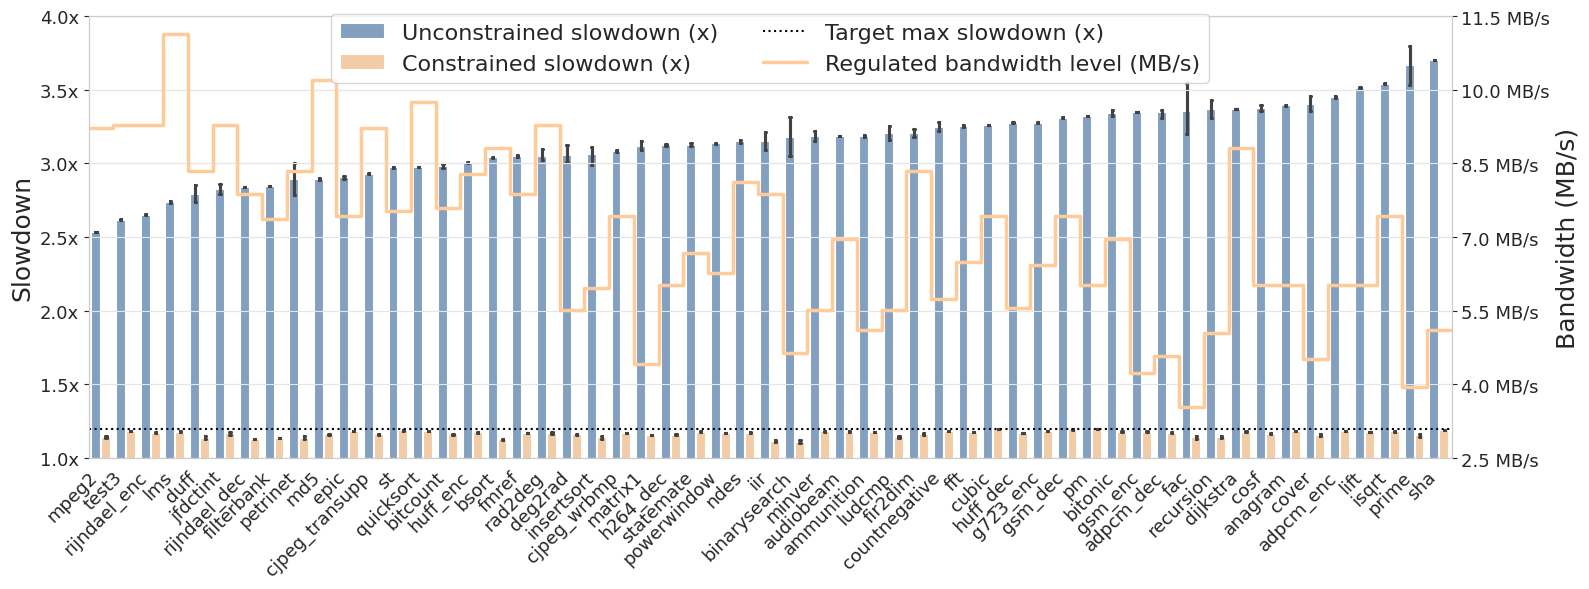

In [13]:
full_res_df = taclebench_df[taclebench_df.core == 'RPU']
stats = taclebench_stats[taclebench_stats.core == 'RPU']

# Plot the boxplots
sns.set_palette("pastel")
sns.set_style("whitegrid", {"grid.color": ".90"})

plt.figure(figsize=(16, 6))

ax1 = plt.gca()
taclebench_plot(full_res_df, stats, ax1, slowdown_ylim=4)

plt.savefig(os.path.join(output_directory, "taclebench_test.png"))
plt.show()

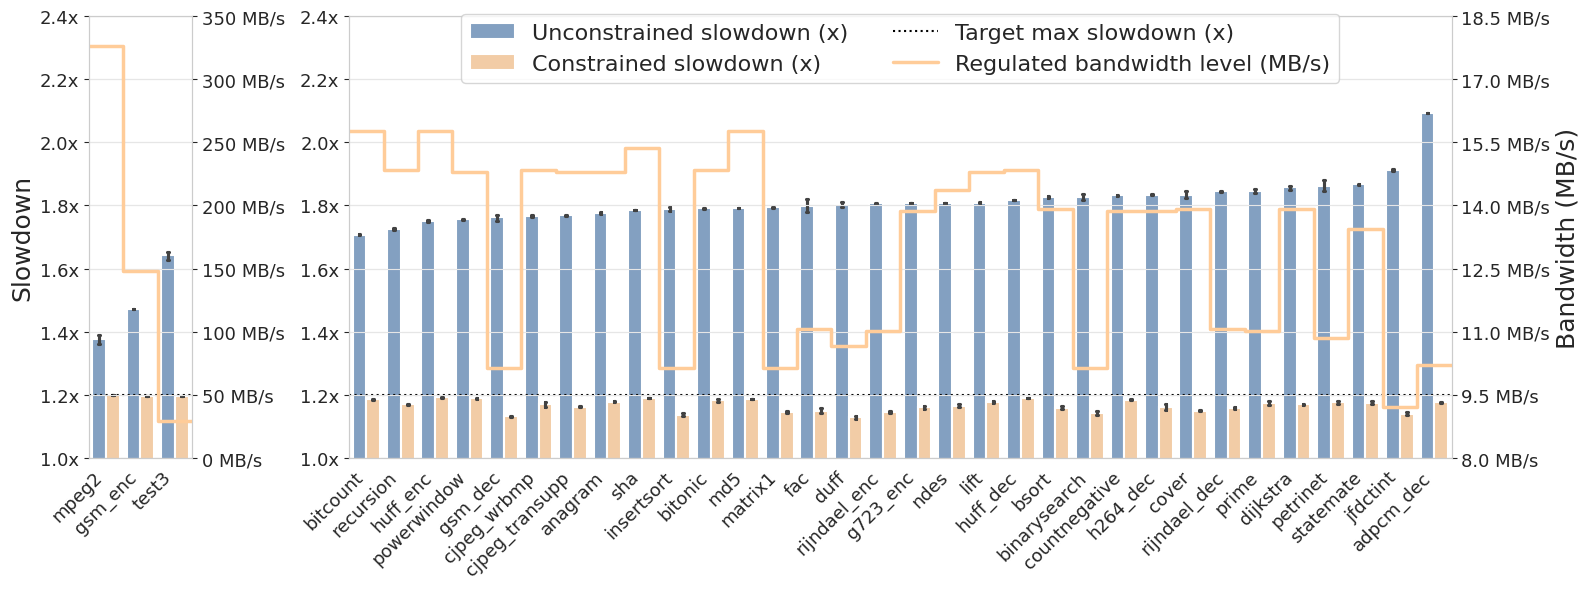

In [14]:
full_res_df = taclebench_df[taclebench_df.core == 'RISCV']
stats = taclebench_stats[taclebench_stats.core == 'RISCV'].copy()
mean = stats.constrained_bandwidth.mean()
stats['threshold'] = stats.apply(lambda r: r.constrained_bandwidth > mean, axis=1)

sns.set_style("whitegrid", {"grid.color": ".90"})

full_res_df = full_res_df.join(stats[['benchmark', 'threshold']].set_index('benchmark'), on='benchmark')
grouped_full_res_df = full_res_df.groupby('threshold')
grouped_stats = stats.groupby('threshold')
max_slowdown = full_res_df.slowdown.max()
slowdown_ylim = 2.4

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, len(grouped_stats.get_group(False)) / len(grouped_stats.get_group(True))]})

for ax, label in [(ax1, True), (ax2, False)]:
    __full_res_df = grouped_full_res_df.get_group(label)
    __stats = grouped_stats.get_group(label)
    taclebench_plot(__full_res_df, __stats, ax, splitted=True, slowdown_ylim=max_slowdown * 1.1, ticks_count=8, left=label, right=not label)

# Save the plot in the specified directory
plt.savefig(os.path.join(output_directory, "taclebench_riscv_test.png"))
plt.show()